# ** Weather Data Analysis **

## 1. Historische Wetterdaten müssen aus einer CSV-Datei geladen werden

In [2]:
import pandas as pd
import numpy as np


#data lesen
df = pd.read_parquet("daily_weather.parquet")

# daten anzeigen
print("daten (erste 5 Zeilen):")
print(df.head())

daten (erste 5 Zeilen):
  station_id city_name       date  season  avg_temp_c  min_temp_c  max_temp_c  \
0      41515  Asadabad 1957-07-01  Summer        27.0        21.1        35.6   
1      41515  Asadabad 1957-07-02  Summer        22.8        18.9        32.2   
2      41515  Asadabad 1957-07-03  Summer        24.3        16.7        35.6   
3      41515  Asadabad 1957-07-04  Summer        26.6        16.1        37.8   
4      41515  Asadabad 1957-07-05  Summer        30.8        20.0        41.7   

   precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
0               0.0            NaN               NaN                 NaN   
1               0.0            NaN               NaN                 NaN   
2               1.0            NaN               NaN                 NaN   
3               4.1            NaN               NaN                 NaN   
4               0.0            NaN               NaN                 NaN   

   peak_wind_gust_kmh  avg_sea_l

## 2. Alle Datumswerte sind korrekt zu interpretieren und zu standardisieren

In [3]:
#  Datum standardisieren 
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

In [4]:
print("\nFehlende Werte pro Spalte:")
print(df.isnull().sum())


Fehlende Werte pro Spalte:
station_id                       0
city_name                    13993
date                             0
season                           0
avg_temp_c                 6230907
min_temp_c                 5718229
max_temp_c                 5539346
precipitation_mm           6642500
snow_depth_mm             24208615
avg_wind_dir_deg          24183195
avg_wind_speed_kmh        22350295
peak_wind_gust_kmh        26514277
avg_sea_level_pres_hpa    23618606
sunshine_total_min        26614302
dtype: int64


## 3.Fehlende oder fehlerhafte Wetterdaten sollen erkannt und bereinigt werden. 

In [5]:
# Fehlerhafte Werte erkennen
# Annahmen für Fehler:
# - Temperaturen: min_temp_c < -50 oder max_temp_c > 50 sind unrealistisch
# - avg_temp_c sollte zwischen min_temp_c und max_temp_c liegen
# - Niederschlag: precipitation_mm < 0 ist ungültig
temp_errors = df[(df['min_temp_c'] < -50) | (df['max_temp_c'] > 50) | 
                 (df['avg_temp_c'] < -50) | (df['avg_temp_c'] > 50) |
                 (df['avg_temp_c'] < df['min_temp_c']) | (df['avg_temp_c'] > df['max_temp_c'])]
precip_errors = df[df['precipitation_mm'] < 0]

print("\nFehlerhafte Temperaturwerte:")
print(temp_errors)
print("\nFehlerhafte Niederschlagswerte:")
print(precip_errors)


Fehlerhafte Temperaturwerte:
      station_id city_name        date  season  avg_temp_c  min_temp_c  \
5202       38954  Fayzabad  1914-02-28  Winter        -3.3        -3.2   
6228       38954  Fayzabad  1916-12-20  Winter        -5.6        -4.5   
6229       38954  Fayzabad  1916-12-21  Winter        -6.3        -2.4   
6230       38954  Fayzabad  1916-12-22  Winter        -5.9        -1.9   
6231       38954  Fayzabad  1916-12-23  Winter        -5.8        -2.1   
...          ...       ...         ...     ...         ...         ...   
9693       67975  Masvingo  1979-12-04  Summer        19.5        20.6   
10330      67975  Masvingo  1981-09-01  Spring        13.4        12.8   
10548      67975  Masvingo  1982-04-07  Autumn        29.4        13.4   
11114      67975  Masvingo  1983-10-25  Spring        17.4        18.1   
12709      67975  Masvingo  1988-03-07  Autumn        19.7        19.9   

       max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
5202     

In [6]:
# Daten bereinigen
# Fehlerhafte Werte zu NaN setzen
df['avg_temp_c'] = np.where((df['avg_temp_c'] < -50) | (df['avg_temp_c'] > 50) | 
                            (df['avg_temp_c'] < df['min_temp_c']) | (df['avg_temp_c'] > df['max_temp_c']), 
                            np.nan, df['avg_temp_c'])
df['min_temp_c'] = np.where(df['min_temp_c'] < -50, np.nan, df['min_temp_c'])
df['max_temp_c'] = np.where(df['max_temp_c'] > 50, np.nan, df['max_temp_c'])
df['precipitation_mm'] = np.where(df['precipitation_mm'] < 0, np.nan, df['precipitation_mm'])

# Fehlende Werte interpolieren
df['avg_temp_c'] = df['avg_temp_c'].interpolate(method='linear')
df['min_temp_c'] = df['min_temp_c'].interpolate(method='linear')
df['max_temp_c'] = df['max_temp_c'].interpolate(method='linear')
df['precipitation_mm'] = df['precipitation_mm'].interpolate(method='linear')

In [7]:
# Bereinigte Daten anzeigen
print("\nBereinigte Daten :")
print(df.head())



Bereinigte Daten :
  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer        27.0        21.1   
1      41515  Asadabad  1957-07-02  Summer        22.8        18.9   
2      41515  Asadabad  1957-07-03  Summer        24.3        16.7   
3      41515  Asadabad  1957-07-04  Summer        26.6        16.1   
4      41515  Asadabad  1957-07-05  Summer        30.8        20.0   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0        35.6               0.0            NaN               NaN   
1        32.2               0.0            NaN               NaN   
2        35.6               1.0            NaN               NaN   
3        37.8               4.1            NaN               NaN   
4        41.7               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     NaN   
1           

## 4. Temperaturen ggf. in Celsius (oder andere Einheiten) umrechnen.

In [8]:
# Temperaturen ggf. in eine andere Einheit umrechnen
# Annahme: Daten sind aktuell in Celsius, Ziel ist z. B. Fahrenheit
aktuelle_einheit = "celsius"  
ziel_einheit = "fahrenheit"  

# Umrechnungsfunktionen definieren
def celsius_zu_fahrenheit(c):
    return (c * 9/5) + 32

def fahrenheit_zu_celsius(f):
    return (f - 32) * 5/9

In [9]:
# Umrechnung durchführen
if aktuelle_einheit.lower() != ziel_einheit.lower():
    if ziel_einheit.lower() == "fahrenheit" and aktuelle_einheit.lower() == "celsius":
        df['avg_temp_c'] = df['avg_temp_c'].apply(celsius_zu_fahrenheit)
        df['min_temp_c'] = df['min_temp_c'].apply(celsius_zu_fahrenheit)
        df['max_temp_c'] = df['max_temp_c'].apply(celsius_zu_fahrenheit)
        # Spalten umbenennen
        #df = df.rename(columns={
         #   'avg_temp_c': 'avg_temp_f',
         #   'min_temp_c': 'min_temp_f',
         #   'max_temp_c': 'max_temp_f'
        #})
        print(f"\nTemperaturen von {aktuelle_einheit} nach {ziel_einheit} umgerechnet.")
    elif ziel_einheit.lower() == "celsius" and aktuelle_einheit.lower() == "fahrenheit":
        df['avg_temp_c'] = df['avg_temp_c'].apply(fahrenheit_zu_celsius)
        df['min_temp_c'] = df['min_temp_c'].apply(fahrenheit_zu_celsius)
        df['max_temp_c'] = df['max_temp_c'].apply(fahrenheit_zu_celsius)
        print(f"\nTemperaturen von {aktuelle_einheit} nach {ziel_einheit} umgerechnet.")
    else:
        print("\nFehler: Ungültige Einheitenkombination.")
else:
    print(f"\nKeine Umrechnung nötig, Daten sind bereits in {aktuelle_einheit}.")


Temperaturen von celsius nach fahrenheit umgerechnet.


In [10]:
print("\nBereinigte und umgerechnete Daten :")
print(df.head())


Bereinigte und umgerechnete Daten :
  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer       80.60       69.98   
1      41515  Asadabad  1957-07-02  Summer       73.04       66.02   
2      41515  Asadabad  1957-07-03  Summer       75.74       62.06   
3      41515  Asadabad  1957-07-04  Summer       79.88       60.98   
4      41515  Asadabad  1957-07-05  Summer       87.44       68.00   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0       96.08               0.0            NaN               NaN   
1       89.96               0.0            NaN               NaN   
2       96.08               1.0            NaN               NaN   
3      100.04               4.1            NaN               NaN   
4      107.06               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     Na

## 5. Berechnung der täglichen Durchschnittstemperaturen.

In [11]:
#Berechnung der täglichen Durchschnittstemperaturen
# Neue Spalte mit Durchschnitt aus min_temp_f und max_temp_f berechnen
df['tag_avg_temp_c'] = (df['min_temp_c'] + df['max_temp_c']) / 2

print(df.head())

  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer       80.60       69.98   
1      41515  Asadabad  1957-07-02  Summer       73.04       66.02   
2      41515  Asadabad  1957-07-03  Summer       75.74       62.06   
3      41515  Asadabad  1957-07-04  Summer       79.88       60.98   
4      41515  Asadabad  1957-07-05  Summer       87.44       68.00   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0       96.08               0.0            NaN               NaN   
1       89.96               0.0            NaN               NaN   
2       96.08               1.0            NaN               NaN   
3      100.04               4.1            NaN               NaN   
4      107.06               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     NaN   
1                 NaN           

## 6. Identikation von Maximal- und Minimaltemperaturen.


In [12]:
# Identifikation von Maximal- und Minimaltemperaturen
global_max_temp = df['max_temp_c'].max()
global_min_temp = df['min_temp_c'].min()

print ("max_temp :", global_max_temp , ziel_einheit )
print ("min_temp : ", global_min_temp ,   ziel_einheit)

max_temp : 122.0 fahrenheit
min_temp :  -58.0 fahrenheit


7. Berechnung von Mittelwert, Median und Standardabweichung für verschiedene Parameter.

8.  Analyse und Visualisierung saisonaler Muster (z. B. Sommer vs. Winter).


9. Erstellung interaktiver Visualisierungen (z. B. Liniendiagramme zur Temperaturentwicklung).

10. Auswertung von zusätzlichen Wetterparametern wie Niederschlag und Luftfeuchtigkeit9. 

11. Kombinierte Darstellung mehrerer Wetterparameter in einem Diagramm.

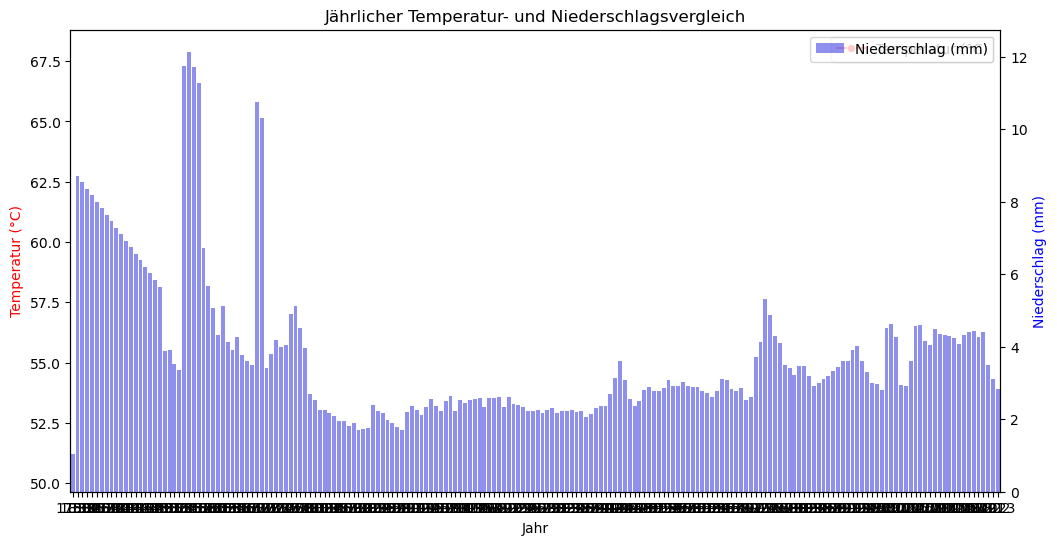

In [14]:
df['year'] = pd.to_datetime(df['date']).dt.year
df_yearly = df.groupby('year')[['avg_temp_c', 'precipitation_mm']].mean().reset_index()

# Erstellen des Diagramms
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.lineplot(x=df_yearly['year'], y=df_yearly['avg_temp_c'], color='red', marker='o', label='Temperatur (°C)')

# Zweite Achse für Niederschlag
ax2 = ax.twinx()
sns.barplot(x=df_yearly['year'], y=df_yearly['precipitation_mm'], ax=ax2, color='blue', alpha=0.5, label='Niederschlag (mm)')

# Titel & Achsenbeschriftung
ax.set_title('Jährlicher Temperatur- und Niederschlagsvergleich')
ax.set_xlabel('Jahr')
ax.set_ylabel('Temperatur (°C)', color='red')
ax2.set_ylabel('Niederschlag (mm)', color='blue')

# Anzeigen des Diagramms
plt.show()

In [ ]:
# 12. Datenaggregation nach Tag, Woche, Monat
df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week
df_weekly = df.groupby('week')[['avg_temp_c', 'precipitation_mm']].mean()
print("Wöchentliche Durchschnittswerte:")
print(df_weekly.head())
#....

Wöchentliche Durchschnittswerte:
      avg_temp_c  precipitation_mm
week                              
1      49.035630          3.085179
2      48.787663          2.998007
3      48.644711          2.972176
4      48.848529          3.001164
5      49.232630          3.001550
